In [1]:
import gym
import MCTSnet
import copy
import torch
from importlib import reload
from IPython import display
import time
import PIL
import copy
import marshal
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Testing environment

In [2]:
env = gym.make("SokobanEnc-v0")

In [3]:
len(env.solution)

15

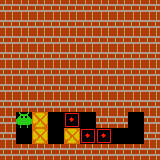

In [4]:
env.render()

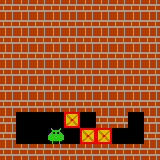

In [5]:
test = []
n_env = copy.deepcopy(env)
for k in reversed(n_env.solution):
    display.clear_output(wait=True)
    res = n_env.step(k)
    display.display(n_env.render())
    time.sleep(0.05)
    test.append(marshal.dumps(res[0]))

In [6]:
len(list(set(test)))

15

# Testing the four neural networks

In [7]:
e = MCTSnet.models.embedding.Epsilon()

In [8]:
state = torch.Tensor(res[0]).to(device)
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [9]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [10]:
reward = torch.tensor([res[1]], requires_grad=True).to(device)
action = torch.tensor([3.], requires_grad=True).to(device)

In [11]:
b = MCTSnet.models.backup.BetaMLP()

In [12]:
h_s = b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

In [13]:
r = MCTSnet.models.readout.Rho()

In [14]:
r(h_s)

tensor([[0.1349, 0.1278, 0.1625, 0.0956, 0.0961, 0.1294, 0.1084, 0.1452]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [15]:
pi = MCTSnet.models.policy.Pi()
actions = pi(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape(-1, 9, 128))

In [16]:
actions

tensor([[0.1265, 0.1194, 0.1379, 0.1195, 0.1249, 0.1194, 0.1194, 0.1329]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [17]:
torch.argmax(actions)

tensor(2, device='cuda:0')

In [18]:
state.shape

torch.Size([4, 10, 10])

# Testing the full MCTSnet

In [19]:
m_net = MCTSnet.models.MCTSnet.MCTSnet(b, e, pi, r)
m_net.env = env
m_net.reset_tree(state.reshape((-1, 4, 10, 10)))
prediction = m_net(state.reshape((-1, 4, 10, 10)).to(device))

In [20]:
prediction

tensor([[0.1280, 0.1279, 0.1534, 0.1032, 0.1166, 0.1252, 0.1089, 0.1368]],
       device='cuda:0', grad_fn=<SoftmaxBackward>)

In [21]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(m_net.parameters(), lr=0.0001)

### Checking that gradients are computed (is the model differentiable ?)

In [22]:
optimizer.zero_grad()
loss = criterion(prediction, torch.tensor([[1.,0.,0.,0.,0.,0.,0.,0.]]).to(device))
loss.backward()

In [23]:
m_net.backup.fc1.weight.grad

tensor([[0., 0., 0.,  ..., 0., -0., 0.],
        [0., 0., 0.,  ..., 0., -0., 0.],
        [0., 0., 0.,  ..., 0., -0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., -0., 0.],
        [0., 0., 0.,  ..., 0., -0., 0.],
        [0., 0., 0.,  ..., 0., -0., 0.]], device='cuda:0')

In [24]:
m_net.embedding.input.weight.grad

tensor([[[[-1.1382e-07, -1.6833e-07, -1.5784e-07],
          [-7.1960e-08, -7.0364e-08, -8.1342e-08],
          [-1.2539e-07, -1.1542e-07, -9.8338e-08]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00, -5.9881e-10, -1.0536e-08],
          [ 8.0533e-09, -7.8277e-09, -2.4269e-08]],

         [[ 7.9711e-09,  0.0000e+00, -5.9881e-10],
          [-1.4048e-08,  3.4844e-10,  1.4342e-10],
          [ 9.1757e-09,  2.2347e-09,  7.2924e-10]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],


        [[[-2.2165e-08,  7.6426e-10,  2.7363e-09],
          [ 0.0000e+00,  0.0000e+00, -1.0096e-08],
          [-9.5667e-09, -9.5667e-09, -9.5667e-09]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 4.7080e-09,  1.0675e-09, -6.0100e-09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

         [[ 0.0000e+00,  4.7080e-09,  1.0675e-09],
          [ 7.642

as "expected" the policy doesn't learn and may require additionnal work

In [25]:
m_net.policy.piL.fc1.weight.grad

In [26]:
m_net.readout.fc1.weight.grad

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [27]:
m_net.state_dict

<bound method Module.state_dict of MCTSnet(
  (backup): BetaMLP(
    (fc1): Linear(in_features=258, out_features=128, bias=True)
  )
  (embedding): Epsilon(
    (input): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (final): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (out): Linear(in_features=3200, out_features=128, bias=True)
  )
  (policy): Pi(
    (piL): PiLogits(
      (fc1): Linear(in_features=128, out_features=8, bias=True)
    )
    (piPL): PiPriorLogits(
      (input): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (final): Conv2d(32,

# Trainer

In [28]:
reload(MCTSnet.trainer)
reload(MCTSnet)
# sokoban = MCTSnet.MCTSnetSokoban((4, 10, 10), n_embeddings=128, n_actions=4, n_simulations=10)

<module 'MCTSnet' from 'F:\\Projets\\MCTSnet\\MCTSnet\\__init__.py'>

In [29]:
# sokoban.train(500)

# Attempt at Mouse game

In [124]:
reload(MCTSnet.trainer)
reload(MCTSnet.mouse.game)
env = MCTSnet.mouse.game.EnvironmentExploring()

In [125]:
state = env.reset()

In [126]:
state.shape

(3, 14, 14)

In [127]:
mnet = MCTSnet.trainer.MCTSnetMouse()

In [128]:
state_tensor = torch.tensor([state]).float().cuda()
state_tensor

tensor([[[[-2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
           -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000],
          [-2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
           -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000],
          [-2.0000, -2.0000,  0.0000,  0.0000,  0.5000,  0.0000, -1.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -2.0000, -2.0000],
          [-2.0000, -2.0000,  0.0000, -1.0000,  0.0000,  0.0000,  0.5000,
            0.0000,  0.0000, -1.0000, -1.0000,  0.5000, -2.0000, -2.0000],
          [-2.0000, -2.0000,  0.0000,  0.0000,  0.5000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -2.0000, -2.0000],
          [-2.0000, -2.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.5000,  0.0000,  0.0000,  0.5000,  0.0000, -2.0000, -2.0000],
          [-2.0000, -2.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.

In [129]:
mnet.model.reset_tree(state_tensor)
mnet.model.env = env
mnet.model(state_tensor)

tensor([[0.2280, 0.2342, 0.2617, 0.2761]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

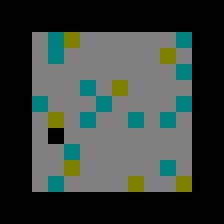

KeyboardInterrupt: 

In [130]:
mnet.train(1, 1, 100)